In [1]:
from keras.datasets import mnist    
from scipy.io import loadmat
from models.utils import ResNet18, split_dataframe, detect_drifts
from skimage.transform import resize
import keras
import numpy as np
import models.unmasking_drift_detector as unm
import models.d3_drift_detector as d3
import matplotlib.pyplot as plt

2024-02-13 15:08:15.161954: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-13 15:08:15.192679: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 15:08:15.192699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 15:08:15.193375: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 15:08:15.197784: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-13 15:08:15.198329: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
(mnist_images, _), (_, _) = mnist.load_data()
mnist_images = resize(mnist_images, (mnist_images.shape[0],32,32,3))

svhn_data = loadmat('train_32x32.mat')
svhn_images, svhn_labels = svhn_data['X'], svhn_data['y']
svhn_images = np.moveaxis(svhn_images, -1, 0)
cap = svhn_images.shape[0] // 2
idx = int(0.8 * cap)

In [3]:
svhn_labels -= 1
X_train, X_test = svhn_images[:idx], svhn_images[idx:cap]
y_train, y_test = svhn_labels[:idx], svhn_labels[idx:cap]

In [4]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [5]:
model = ResNet18(input_shape=(32, 32, 3), n_classes=10)

In [6]:
model.compile(optimizer=keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=64, epochs=4, validation_data=(X_test, y_test))

Epoch 1/4
458/458 [==============================] - 446s 964ms/step - loss: 1.0940 - accuracy: 0.6458 - val_loss: 0.6814 - val_accuracy: 0.7763
Epoch 2/4
458/458 [==============================] - 446s 974ms/step - loss: 0.4923 - accuracy: 0.8468 - val_loss: 0.5221 - val_accuracy: 0.8397
Epoch 3/4
458/458 [==============================] - 446s 973ms/step - loss: 0.3994 - accuracy: 0.8775 - val_loss: 0.5833 - val_accuracy: 0.8093
Epoch 4/4
458/458 [==============================] - 445s 972ms/step - loss: 0.3349 - accuracy: 0.8981 - val_loss: 0.6230 - val_accuracy: 0.8204


In [7]:
extract_features_model = keras.Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)

In [8]:
svhn_images
mnist_images
drifted_data = np.empty((0, 32, 32, 3))
i = 0
last_index = 0
current_index = 0
ground_truth_drifts = []

dimension_limit = 0.6 * (svhn_images.shape[0] + 0.5*mnist_images.shape[0])
while drifted_data.shape[0] < dimension_limit:
    current_index += np.random.choice([400, 800, 1200, 1600])
    if i % 2 == 0:
        if i != 0:
            ground_truth_drifts.append(drifted_data.shape[0])
        svhn_batch = svhn_images[last_index:current_index]
        drifted_data = np.concatenate((drifted_data, svhn_batch), axis=0)
    else:
        # ground_truth_drifts.append(drifted_data.shape[0])
        batch = np.concatenate((svhn_batch, mnist_images[last_index:current_index]), axis=0)
        np.random.shuffle(batch)
        drifted_data = np.concatenate((drifted_data, batch), axis=0)
    i += 1
    last_index = current_index

In [9]:
ground_truth_drifts, drifted_data.shape

([3200,
  8000,
  10800,
  12000,
  15200,
  19600,
  23200,
  25600,
  29600,
  32400,
  36000,
  40000,
  42800,
  45600,
  49200,
  52800,
  56400,
  60000],
 (64000, 32, 32, 3))

In [10]:
features = extract_features_model.predict(drifted_data)
features.shape

2024-02-13 15:38:34.818734: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 786432000 exceeds 10% of free system memory.


 500/2000 [======>.......................] - ETA: 16s

2000/2000 [==============================] - 24s 12ms/step


(64000, 512)

In [11]:
batch_size = 400
data_splitted = split_dataframe(features, batch_size)
ground_truth_drifts_batch = np.array(ground_truth_drifts) / 400
ground_truth_drifts_batch = ground_truth_drifts_batch.astype(int)
ground_truth_drifts_batch

array([  8,  20,  27,  30,  38,  49,  58,  64,  74,  81,  90, 100, 107,
       114, 123, 132, 141, 150])

In [12]:
np.save("ground_truth_drifts_batch.npy", ground_truth_drifts_batch)
np.save("features.npy", features)

D3:


0.6363636363636364
Unmasking:
Threshold = 0.5
0.1956521739130435
Threshold = 0.53
0.35294117647058826
Threshold = 0.54
0.5142857142857142
Threshold = 0.55
0.48484848484848486
Threshold = 0.56
0.6071428571428571
Threshold = 0.57
0.56
Threshold = 0.6
0.5263157894736842


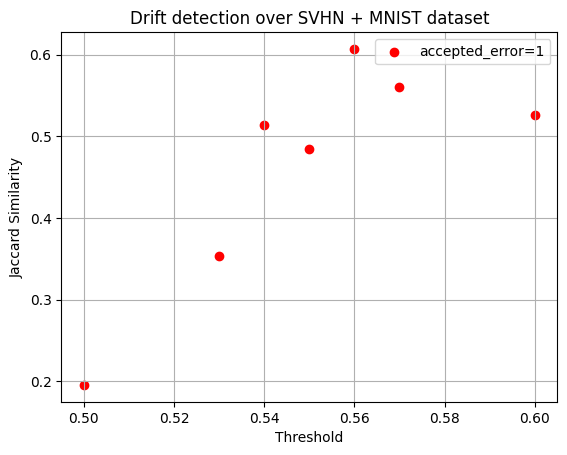

In [13]:

thresholds = [0.5, 0.53, 0.54, 0.55, 0.56, 0.57, 0.6]
jaccard_sim_unm = []

print("D3:")
sim_d3 = detect_drifts(data_splitted, d3.drift_detector, ground_truth_drifts_batch, accepted_error=1, show_drifts=False)
print(sim_d3)

print("Unmasking:")
for thr in thresholds:
    print(f"Threshold = {thr}")
    sim_unm = detect_drifts(data_splitted, unm.drift_detector, ground_truth_drifts_batch, show_drifts=False, accepted_error=1, threshold=thr, min_feature_percentage_remaining=0.05)
    print(sim_unm)
    jaccard_sim_unm.append(sim_unm)




plt.xlabel('Threshold')
plt.ylabel('Jaccard Similarity')
plt.title('Drift detection over SVHN + MNIST dataset')

plt.scatter(thresholds, jaccard_sim_unm, marker='o', color='red', label='accepted_error=1')
# plt.plot(percentages, [sim_d3]*len(percentages), c='blue', label='d3')
plt.grid()
plt.legend()
# plt.savefig('/images/svhn_jaccard_thresholds_error1.png')
plt.show()


D3:
0.6521739130434783
Unmasking:
Threshold = 0.5
0.15384615384615385
Threshold = 0.53
0.32075471698113206
Threshold = 0.54
0.425
Threshold = 0.55
0.40540540540540543
Threshold = 0.56
0.4827586206896552
Threshold = 0.57
0.46153846153846156
Threshold = 0.6
0.36363636363636365


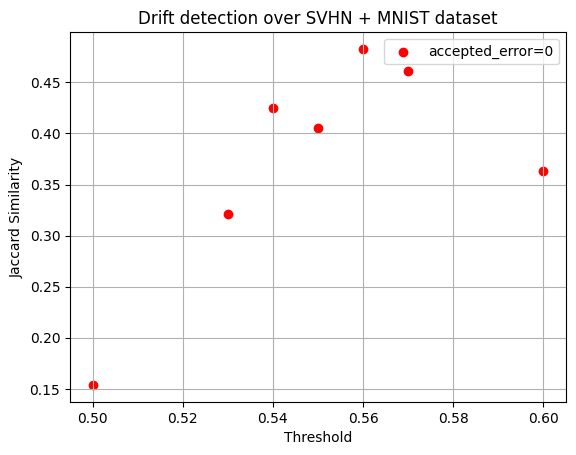

In [14]:

thresholds = [0.5, 0.53, 0.54, 0.55, 0.56, 0.57, 0.6]
jaccard_sim_unm = []

print("D3:")
sim_d3 = detect_drifts(data_splitted, d3.drift_detector, ground_truth_drifts_batch, accepted_error=0, show_drifts=False)
print(sim_d3)

print("Unmasking:")
for thr in thresholds:
    print(f"Threshold = {thr}")
    sim_unm = detect_drifts(data_splitted, unm.drift_detector, ground_truth_drifts_batch, show_drifts=False, accepted_error=0, threshold=thr, min_feature_percentage_remaining=0.05)
    print(sim_unm)
    jaccard_sim_unm.append(sim_unm)




plt.xlabel('Threshold')
plt.ylabel('Jaccard Similarity')
plt.title('Drift detection over SVHN + MNIST dataset')

plt.scatter(thresholds, jaccard_sim_unm, marker='o', color='red', label='accepted_error=0')
plt.grid()
# plt.plot(percentages, [sim_d3]*len(percentages), c='blue', label='d3')
plt.legend()
# plt.savefig('/images/svhn_jaccard_thresholds_error0.png')
plt.show()

Unmasking:
Percent = 0.05


0.5161290322580645
Percent = 0.15
0.5333333333333333
Percent = 0.25
0.5714285714285714
Percent = 0.35
0.4666666666666667
Percent = 0.45
0.4838709677419355
Percent = 0.55
0.5
Percent = 0.65
0.5161290322580645


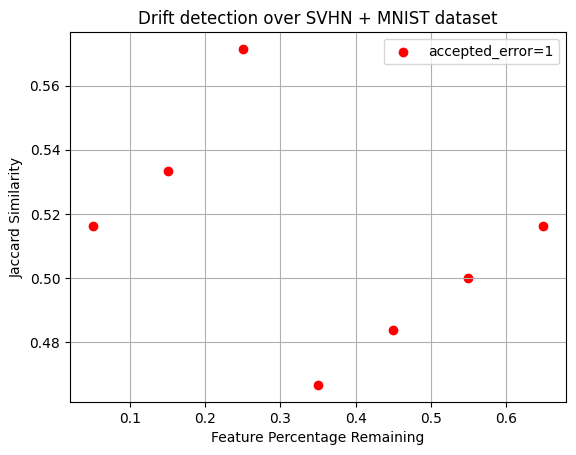

In [15]:
percents = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65]
jaccard_sim_unm = []

print("Unmasking:")
for p in percents:
    print(f"Percent = {p}")
    sim_unm = detect_drifts(data_splitted, unm.drift_detector, ground_truth_drifts_batch, show_drifts=False, accepted_error=1, min_feature_percentage_remaining=p)
    print(sim_unm)
    jaccard_sim_unm.append(sim_unm)




plt.xlabel('Feature Percentage Remaining')
plt.ylabel('Jaccard Similarity')
plt.title('Drift detection over SVHN + MNIST dataset')

plt.scatter(percents, jaccard_sim_unm, marker='o', color='red', label='accepted_error=1')
# plt.plot(percentages, [sim_d3]*len(percentages), c='blue', label='d3')
plt.grid()
plt.legend()
# plt.savefig('/images/svhn_jaccard_percents_error1.png')
plt.show()


In [2]:
# print("D3:")
# sim_d3 = detect_drifts(data_splitted, d3.drift_detector, ground_truth_drifts_batch, accepted_error=1, show_drifts=False)
# print(sim_d3)